In [1]:
# -------------------------
# Imports
# -------------------------

import warnings, logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm.auto import tqdm
warnings.filterwarnings("ignore")
logging.getLogger("statsmodels").setLevel(logging.ERROR)

In [2]:
# -------------------------
# Config
# -------------------------

CSV    = "data_main.csv"
DATE   = "date"
TARGET = "log_total_dollar_volume"
EXOG   = "vix_close"

USE_LAGS = True     
MAX_LAGS  = 3

MAX_P = 5
MAX_Q = 5
D_FIXED = 1

SPLITS = [
    dict(train_start=None,          train_end="2022-12-31", test_start="2023-01-01"),
    dict(train_start="2020-03-01",  train_end="2022-12-31", test_start="2023-01-01")
]

# Define model families and their (p,q) grids
MODEL_SPECS = {
    "AR": dict(    p_grid=range(1, MAX_P+1), q_grid=[0],               use_exog=False),
    "ARX": dict(   p_grid=range(1, MAX_P+1), q_grid=[0],               use_exog=True),
    "MA": dict(    p_grid=[0],               q_grid=range(1, MAX_Q+1), use_exog=False),
    "MAX": dict(   p_grid=[0],               q_grid=range(1, MAX_Q+1), use_exog=True),
    "ARIMA": dict( p_grid=range(1, MAX_P+1), q_grid=range(1, MAX_Q+1), use_exog=False),
    "ARIMAX": dict(p_grid=range(1, MAX_P+1), q_grid=range(1, MAX_Q+1), use_exog=True)
}

In [3]:
# -------------------------
# Data
# -------------------------

df = pd.read_csv(CSV, parse_dates=[DATE]).set_index(DATE).sort_index()
df = df.asfreq("B").ffill()

y = df[TARGET].astype(float)
vix_full = df[EXOG].astype(float)

# Build exogenous X from VIX
if USE_LAGS:
    vix_feat = pd.DataFrame({
        f"vix_lag{L}": vix_full.shift(L)
        for L in range(1, MAX_LAGS + 1)
    })
else:
    vix_feat = vix_full.to_frame("vix")

In [4]:
# -------------------------
# Alignment for target variable and exogenous variable
# -------------------------

def align_xy_dropna(y, X):
    y2, X2 = y.align(X, join="inner")
    mask = np.isfinite(y2.values) & np.isfinite(X2.values).all(axis=1)
    return y2[mask], X2[mask]

In [5]:
# -------------------------
# Parameter Estimation
# -------------------------

def aicc(res):
    k = res.params.size
    n = res.nobs
    return res.aic + (2*k*(k+1)) / max(n - k - 1, 1)

def fit_best_sarimax_train(y_train, X_train, p_grid, q_grid, use_exog):
    
    if use_exog:
        y_train, X_train = align_xy_dropna(y_train, X_train)
    else:
        y_train = y_train.dropna().astype(float)
        X_train = None

    best_ic, best_order, best_res = np.inf, None, None

    for p in p_grid:
        for q in q_grid:
            if (p,q) == (0,0):
                continue
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    m = SARIMAX(y_train,
                                exog=X_train if use_exog else None,
                                order=(p, D_FIXED, q),
                                enforce_stationarity=False
                                )
                    r = m.fit(disp=False, method_kwargs={"disp": 0})
                ic = aicc(r)
                if ic < best_ic:
                    best_ic, best_order, best_res = ic, (p, D_FIXED, q), r
            except Exception:
                continue

    return best_order, best_ic, best_res

In [6]:
# -------------------------
# Residual Diagnostics
# -------------------------

def residual_diagnostics(res):
    resid_raw = pd.Series(res.resid).dropna()
    burn = getattr(res, "loglikelihood_burn", 0)
    resid = resid_raw.iloc[burn:]
    n = len(resid)

    p, _, q = res.model.order
    lags = max(5, min(20, int(10 * np.log10(n))))

    dw = durbin_watson(resid)

    lb = acorr_ljungbox(resid, lags=[lags], return_df=True, model_df=p + q)
    _, arch_p, _, _ = het_arch(resid, nlags=lags)
    _, jb_p, _, _ = jarque_bera(resid)

    return {
        "DW": float(dw),
        "LB_p": float(lb["lb_pvalue"].iloc[-1]),
        "ARCH_p": float(arch_p),
        "JB_p": float(jb_p)
    }

In [7]:
def standardize_train_test(X_train_raw: pd.DataFrame, X_test_raw: pd.DataFrame):
    mu = X_train_raw.mean()
    sigma = X_train_raw.std(ddof=1).replace(0, 1)
    Xtr = (X_train_raw - mu) / sigma
    Xte = (X_test_raw - mu) / sigma
    Xtr.columns = [f"{c}_z" for c in Xtr.columns]
    Xte.columns = [f"{c}_z" for c in Xte.columns]
    return Xtr, Xte

In [8]:
# -------------------------
# Forecast
# -------------------------

def forecast_1step_ahead(res_train, y_test, X_test=None):
    res_curr = res_train
    preds = []

    for t in y_test.index:
        exog_t = None if X_test is None else X_test.loc[[t]]
        fc = res_curr.get_forecast(steps=1, exog=exog_t)
        preds.append(float(fc.predicted_mean.iloc[0]))
        res_curr = res_curr.append(endog=y_test.loc[[t]], exog=exog_t, refit=False)

    yhat = pd.Series(preds, index=y_test.index)

    mae  = mean_absolute_error(y_test, yhat)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))

    return {
        "MAE": float(mae),
        "RMSE": float(rmse),
        "y_test": y_test,
        "yhat": yhat
    }

In [9]:
def make_train_test(split):
    tr_end, te_start = split["train_end"], split["test_start"]
    if split["train_start"]:
        y_train = y.loc[split["train_start"]:tr_end]
    else:
        y_train = y.loc[:tr_end]
    y_test = y.loc[te_start:]
    return y_train, y_test

In [10]:
# -------------------------
# Function for running code
# -------------------------

def run_one_split(split_idx):
    sp = SPLITS[split_idx - 1]
    y_train, y_test = make_train_test(sp)

    X_train_raw = vix_feat.loc[y_train.index]
    X_test_raw  = vix_feat.loc[y_test.index]
    Xtr, Xte = standardize_train_test(X_train_raw, X_test_raw)

    rows = []
    
    model_items = list(MODEL_SPECS.items())
    for model_name, spec in tqdm(model_items, desc=f"Split {split_idx} — models", leave=True):
        use_exog = spec["use_exog"]
        X_train = Xtr if use_exog else None
        X_test = Xte if use_exog else None
        
        order, ic, res_train = fit_best_sarimax_train(
            y_train,
            X_train,
            p_grid = spec["p_grid"],
            q_grid = spec["q_grid"],
            use_exog = use_exog
        )
        
        diag = residual_diagnostics(res_train)
        fc = forecast_1step_ahead(res_train, y_test, X_test)
        
        rows.append({
            "split": split_idx,
            "model": model_name,
            "order": order,
            "AICc": ic,
            "MAE": fc["MAE"],
            "RMSE": fc["RMSE"],
            "DW": diag["DW"],
            "LB_p": diag["LB_p"],
            "ARCH_p": diag["ARCH_p"],
            "JB_p": diag["JB_p"],
            "y_test": fc["y_test"],
            "yhat": fc["yhat"]
        })
        
    return rows

In [11]:
# -------------------------
# Collect Results to Data Frame
# -------------------------

ALL_ROWS_FIRST_SPLIT = []
ALL_ROWS_FIRST_SPLIT.extend(run_one_split(1))


Split 1 — models:   0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
split_1_df = (
    pd.DataFrame(ALL_ROWS_FIRST_SPLIT)
    .reset_index(drop=True)
)

print(split_1_df[["split", "model", "order", "AICc", "MAE", "RMSE", "DW", "LB_p", "ARCH_p", "JB_p"]])

   split   model      order         AICc       MAE      RMSE        DW  \
0      1      AR  (5, 1, 0) -4024.995899  0.109752  0.164067  2.002347   
1      1     ARX  (5, 1, 0) -4062.814880  0.109586  0.163627  2.002235   
2      1      MA  (0, 1, 5) -4194.449986  0.106484  0.160063  1.993728   
3      1     MAX  (0, 1, 5) -4242.061164  0.106929  0.159870  1.993965   
4      1   ARIMA  (4, 1, 4) -4402.261314  0.103523  0.156365  2.002627   
5      1  ARIMAX  (5, 1, 5) -4455.095272  0.103532  0.156276  1.991589   

           LB_p        ARCH_p  JB_p  
0  4.896836e-36  1.026540e-58   0.0  
1  9.377771e-36  7.345416e-58   0.0  
2  8.796981e-27  6.579790e-51   0.0  
3  2.135691e-26  9.912417e-49   0.0  
4  2.055508e-10  1.137592e-69   0.0  
5  3.930494e-09  4.049962e-69   0.0  


In [14]:
ALL_ROWS_SECOND_SPLIT = []
ALL_ROWS_SECOND_SPLIT.extend(run_one_split(2))

Split 2 — models:   0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
split_2_df = (
    pd.DataFrame(ALL_ROWS_SECOND_SPLIT)
    .reset_index(drop=True)
)

print(split_2_df[["split", "model", "order", "AICc", "MAE", "RMSE", "DW", "LB_p", "ARCH_p", "JB_p"]])

   split   model      order        AICc       MAE      RMSE        DW  \
0      2      AR  (5, 1, 0) -659.479707  0.111447  0.165002  2.017723   
1      2     ARX  (5, 1, 0) -659.691725  0.111551  0.164451  2.018533   
2      2      MA  (0, 1, 4) -691.448871  0.107760  0.160549  1.992147   
3      2     MAX  (0, 1, 4) -694.470541  0.107951  0.159883  1.990484   
4      2   ARIMA  (2, 1, 1) -700.513980  0.106772  0.159532  1.991810   
5      2  ARIMAX  (2, 1, 1) -703.998681  0.106966  0.158953  1.993434   

       LB_p    ARCH_p           JB_p  
0  0.012512  0.000002  8.422482e-127  
1  0.013116  0.000004  1.510094e-130  
2  0.388713  0.000003  5.225470e-143  
3  0.485223  0.000010  4.362652e-148  
4  0.736958  0.000015  1.484842e-148  
5  0.755000  0.000031  2.513928e-154  


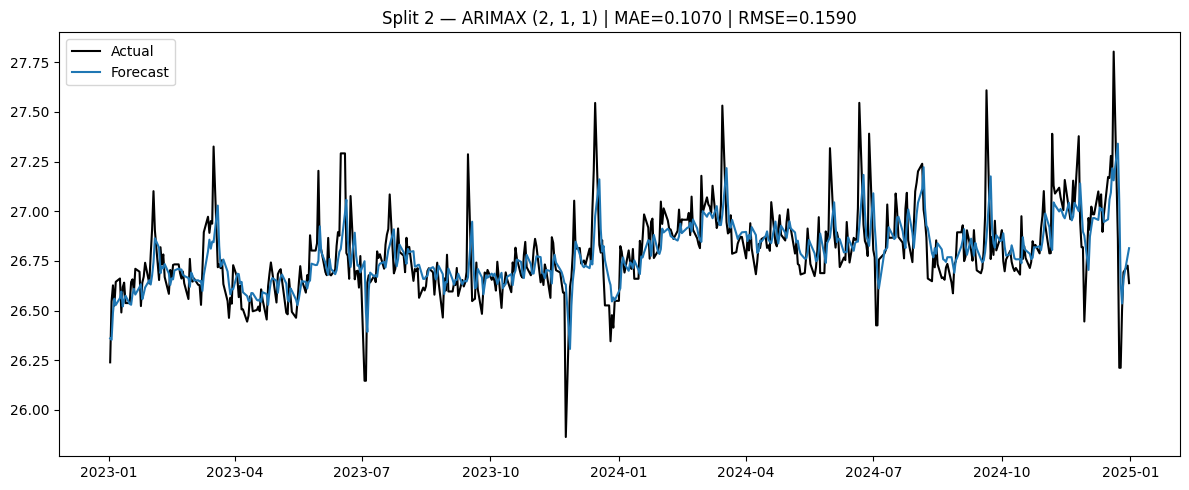

In [18]:
# -------------------------
# Plot
# -------------------------

def plot_forecast(df, model):
    row = df.loc[df["model"] == model].iloc[0]

    y_test = row["y_test"]
    yhat   = row["yhat"]

    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="Actual", lw=1.5, color="black")
    plt.plot(yhat,  label="Forecast", lw=1.5)
    plt.title(f"Split {row['split']} — {model} {row['order']} | MAE={row['MAE']:.4f} | RMSE={row['RMSE']:.4f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(split_2_df, "ARIMAX")